In [ ]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
counts = pd.read_csv('sample_pbmc/pbmc10k_counts.csv',
                  index_col = 0)

empty = pd.read_csv('sample_pbmc/pbmc10k_empty.csv',
                  index_col = 0)

cell_type = pd.read_csv('sample_pbmc/pbmc10k_cell_type.csv',
                  index_col = 0)

pbmc10k_cell_type.csv  pbmc10k_empty.csv
pbmc10k_counts.csv     pbmc10k_pyro_inference_theta.csv


In [ ]:
print(f'Dim of count matrix: {counts.shape}')
print(f'Dim of empty drop matrix: {empty.shape}')
print(f'Dim of cell_type array: {cell_type.shape}')

p = empty.values
p = p.sum(axis = 1)
p = p/p.sum()
print(p, p.shape, type(p))

Dim of count matrix: (14, 7471)
Dim of empty drop matrix: (14, 10000)
Dim of cell_type array: (7471, 1)
[0.17560754 0.17233704 0.11056098 0.05069271 0.06827163 0.06318419
 0.02248467 0.01971383 0.01053827 0.19813763 0.05986827 0.02348399
 0.00785828 0.01726096] (14,) <class 'numpy.ndarray'>


In [ ]:
# Converting data to tensor
print(type(counts))
counts_tensor = torch.from_numpy(counts.values).T.float()
p_tensor = torch.from_numpy(p).float()
cell_type_tensor = torch.from_numpy(cell_type.values).squeeze(axis = 1)



print(counts_tensor[:5,:5], counts_tensor.shape, counts_tensor.dtype)
print(p_tensor, p_tensor.dtype)
print(cell_type_tensor[:10], len(cell_type_tensor), cell_type_tensor.dtype)

<class 'pandas.core.frame.DataFrame'>
tensor([[  30.,  119.,   19.,  472.,  102.],
        [  18.,  207.,   10., 1289.,  128.],
        [  18.,   11.,   17.,   20.,  124.],
        [   5.,   14.,   14.,   19.,  156.],
        [  21., 1014.,   29., 2428.,  204.]]) torch.Size([7471, 14]) torch.float32
tensor([0.1756, 0.1723, 0.1106, 0.0507, 0.0683, 0.0632, 0.0225, 0.0197, 0.0105,
        0.1981, 0.0599, 0.0235, 0.0079, 0.0173]) torch.float32
tensor([1, 1, 4, 4, 1, 1, 1, 2, 2, 9]) 7471 torch.int64


                    CD3   CD4  CD8a  CD14  CD15  CD16  CD56  CD19  CD25  \
AAACCCACATCGGTTA-1   30   119    19   472   102   155   248     3     5   
AAACCCAGTACCGCGT-1   18   207    10  1289   128    72    26     8    15   
AAACCCAGTATCGAAA-1   18    11    17    20   124  1227   491     5    15   
AAACCCAGTCGTCATA-1    5    14    14    19   156  1873   458     4    16   
AAACCCAGTCTACACA-1   21  1014    29  2428   204   148    29     7    52   

                    CD45RA  CD45RO  PD-1  TIGIT  CD127  
AAACCCACATCGGTTA-1     125     156     9      9      8  
AAACCCAGTACCGCGT-1    5268      28    20     11     12  
AAACCCAGTATCGAAA-1    4743      28    25     59     16  
AAACCCAGTCGTCATA-1    4108      21    28     76     17  
AAACCCAGTCTACACA-1     227     492    16     11     15   <class 'pandas.core.frame.DataFrame'>


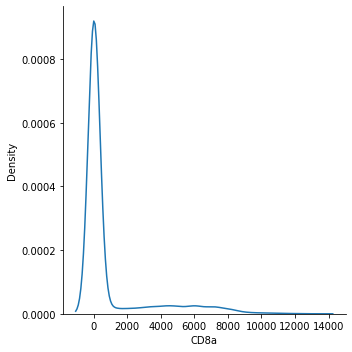

In [ ]:
d = counts.T
print(d.head(), type(d))
sns.displot(d, x = 'CD8a', kind = 'kde')

In [ ]:
class Encoder(nn.Module):
  def __init__(self, ngenes, hidden, dropout):
    super().__init__()
    self.drop = nn.Dropout(dropout)
    self.fc1 = nn.Linear(ngenes, hidden)
    self.fc2 = nn.Linear(hidden, hidden)
    self.fcmu = nn.Linear(hidden, 2)
    self.fclv = nn.Linear(hidden, 2)

    self.bnmu = nn.BatchNorm1d(2, affine = False)
    self.bnlv = nn.BatchNorm1d(2, affine = False)


  def forward(self, inputs):
    h = F.softplus(self.fc1(inputs))
    h = F.softplus(self.fc2(h))
    h = self.drop(h)

    logtheta_loc = self.bnmu(self.fcmu(h))
    logtheta_logvar = self.bnlv(self.fclv(h))
    logtheta_scale = (0.5*logtheta_logvar).exp()
    return logtheta_loc, logtheta_scale


In [ ]:
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, ambient_profile):
    super().__init__()
    self.ambient_profile = ambient_profile
    self.weight = nn.Parameter(torch.empty((out_features, in_features)))
    self.reset_parameters()

  def reset_parameters(self):
    nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

  def forward(self, input):
    # Input: theta. Last col is weight on ambient profile

    # Normalize weight to make it same scale as ambient_profile
    weight_norm = self.weight.t()
    weight_norm = weight_norm / weight_norm.sum(axis = 1, keepdim = True)

    output = torch.mm(input[:,:-1], weight_norm)
    output += torch.outer(input[:,-1], self.ambient_profile)
    return output


In [ ]:
class Decoder(nn.Module):
  def __init__(self, ngenes, nclusters, ambient_profile, dropout):
    super().__init__()
    self.beta = myLinear(nclusters, ngenes, ambient_profile)
    self.bn = nn.BatchNorm1d(ngenes, affine=False)
    self.drop = nn.Dropout(dropout)


  def forward(self, inputs):
    inputs = self.drop(inputs)
    return F.softmax(self.bn(self.beta(inputs)), dim = 1)

In [ ]:
class ProdLDA(nn.Module):
  def __init__(self, ngenes, nclusters, ambient_profile, hidden, dropout):
    super().__init__()
    self.ngenes = ngenes
    self.nclusters = nclusters
    self.ambient_profile = ambient_profile
    self.encoder = Encoder(ngenes, hidden, dropout)
    self.decoder = Decoder(ngenes, nclusters, ambient_profile, dropout)

  def model(self, counts_batch, cell_type_batch):
    pyro.module('decoder', self.decoder)
    with pyro.plate('documents', counts_batch.shape[0]):
      logtheta_loc = counts_batch.new_zeros((counts_batch.shape[0], 2))
      logtheta_scale = counts_batch.new_ones((counts_batch.shape[0], 2))
      logtheta = pyro.sample('logtheta', dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
      theta = F.softmax(logtheta, -1)
      # theta: droplets x 2 : (native ratio n contam ratio)

      # theta_expand: droplet x (ncluster + 1) : (+1 contam ratio)
      theta_expanded = self.expand(theta, cell_type_batch)
      

      count_param = self.decoder(theta_expanded)

      total_count = int(counts_batch.sum(-1).max())
      pyro.sample('obs', dist.Multinomial(total_count, count_param), obs=counts_batch)

  
  def guide(self, counts_batch, cell_type_batch):
    pyro.module('encoder', self.encoder)
    with pyro.plate('documents', counts_batch.shape[0]):
      logtheta_loc, logtheta_scale = self.encoder(counts_batch)
      logtheta = pyro.sample('logtheta', dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

  def beta(self):
    return self.decoder.beta.logweight.cpu().detach().T

  def expand(self, theta, cell_type_batch):
    theta_expand = torch.zeros((theta.shape[0], self.nclusters + 1)).to(device)
    theta_expand[torch.arange(len(cell_type_batch)), cell_type_batch - 1] = theta[:,0] # 0 based
    theta_expand[torch.arange(len(cell_type_batch)), -1] = theta[:, 1]
    return theta_expand


In [ ]:
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

counts_tensor = counts_tensor.to(device)
p_tensor = p_tensor.to(device)
cell_type_tensor = cell_type_tensor.to(device)

ngenes = counts_tensor.shape[1]
# print(ngenes.device)
nclusters = cell_type_tensor.max()
# print(nclusters.device)
print(f"Num of cell types: {nclusters}")


batch_size = 32
lr = 1e-3
num_epochs = 50

cuda
Num of cell types: 12


In [ ]:
pyro.clear_param_store()

prodLDA = ProdLDA(
    ngenes = ngenes,
    nclusters = nclusters,
    ambient_profile = p_tensor,
    hidden = 100,
    dropout = 0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({'lr': lr})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(counts_tensor.shape[0] / batch_size))

bar = trange(num_epochs)
loss_store = []
for epoch in bar:
  running_loss = 0.0
  for i in range(num_batches):
    counts_batch = counts_tensor[i*batch_size:(i+1)*batch_size, :]
    cell_type_batch = cell_type_tensor[i*batch_size:(i+1)*batch_size]
    loss = svi.step(counts_batch, cell_type_batch)

    for p in prodLDA.decoder.beta.parameters(): # beta param are positive
      p.data.clamp_(min = 0)

    running_loss += loss / counts_batch.size(0)

  bar.set_postfix(epoch_loss = '{:.2e}'.format(running_loss))
  if epoch % 10 == 0:
    print(f"Loss: {loss}")


  2%|▏         | 1/50 [00:02<02:19,  2.84s/it, epoch_loss=1.78e+06]

Loss: 75637.421875


 22%|██▏       | 11/50 [00:28<01:20,  2.07s/it, epoch_loss=1.10e+06]

Loss: 71451.375


 42%|████▏     | 21/50 [00:47<00:55,  1.91s/it, epoch_loss=1.10e+06]

Loss: 68684.390625


 62%|██████▏   | 31/50 [01:06<00:36,  1.92s/it, epoch_loss=1.11e+06]

Loss: 76144.90625


 82%|████████▏ | 41/50 [01:29<00:20,  2.24s/it, epoch_loss=1.09e+06]

Loss: 72850.0546875


100%|██████████| 50/50 [01:46<00:00,  2.13s/it, epoch_loss=1.09e+06]


In [ ]:
beta = prodLDA.decoder.beta.weight.cpu().detach().exp().t()
print(beta[:5,:5])

print(beta.shape)
beta_pos = beta.detach().cpu().numpy() >0
print(beta_pos.sum(), 12*14)

print(pyro.get_param_store().keys())

# Verify the ambient dist does not change after learning
print(f"Original ambient profile: {p_tensor.detach().cpu().numpy()}")
print(f"Correlation between the true ambient and model stored ambient profile: {np.corrcoef(p_tensor.detach().cpu().numpy(),prodLDA.decoder.beta.ambient_profile.detach().cpu().numpy())}")

tensor([[1.0000, 1.0768, 1.0000, 1.4555, 1.3039],
        [1.6042, 1.5053, 1.0000, 1.0057, 1.0424],
        [1.4792, 1.6089, 1.0000, 1.0182, 1.0592],
        [1.0000, 1.0000, 1.2027, 1.0555, 1.1311],
        [1.3515, 1.0000, 1.5861, 1.0178, 1.0536]])
torch.Size([12, 14])
168 168
dict_keys(['encoder$$$fc1.weight', 'encoder$$$fc1.bias', 'encoder$$$fc2.weight', 'encoder$$$fc2.bias', 'encoder$$$fcmu.weight', 'encoder$$$fcmu.bias', 'encoder$$$fclv.weight', 'encoder$$$fclv.bias', 'decoder$$$beta.weight'])
Original ambient profile: [0.17560755 0.17233704 0.11056098 0.05069271 0.06827163 0.06318419
 0.02248467 0.01971383 0.01053827 0.19813763 0.05986827 0.02348399
 0.00785828 0.01726096]
Correlation between the true ambient and model stored ambient profile: [[1. 1.]
 [1. 1.]]


In [ ]:
# Get logtheta_loc and logtheta_scale to sample theta
logtheta_loc, logtheta_scale = prodLDA.encoder(counts_tensor)
print(logtheta_loc.shape, logtheta_scale.shape)

# logtheta = pyro.sample('logtheta', dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
theta = F.softmax(logtheta_loc, -1)

theta = theta.cpu().detach()

print(theta[:,:10], theta.shape)

df = pd.DataFrame(theta.numpy())
# print(df.head(), df.shape)
df.to_csv('pbmc10k_pyro_inference_theta.csv')

torch.Size([7471, 2]) torch.Size([7471, 2])
tensor([[6.1048e-01, 3.8952e-01],
        [1.4224e-04, 9.9986e-01],
        [3.5928e-02, 9.6407e-01],
        ...,
        [6.3296e-01, 3.6704e-01],
        [7.3159e-01, 2.6841e-01],
        [7.9211e-01, 2.0789e-01]]) torch.Size([7471, 2])
